<a href="https://colab.research.google.com/github/andrebjardim/AI-ML-Data-Salaries-Project/blob/main/ai_ml_data_salaries_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing In-Office Salary Trends in AI, Data, and Machine Learning Roles** (by André Jardim)

#**Data Setup Process**

**Install Missing Libraries (if not already installed)**

In [ ]:
import subprocess
import sys

required_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'sqlalchemy', 'prettytable', 'pycountry', 'ipython-sql', 'scipy', 'scipy.stats']

for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])

**Import Libraries**

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prettytable
import pycountry
from sqlalchemy import create_engine
from scipy import stats
from scipy.stats import ks_2samp

**Load and Save the Dataset**

In [ ]:
url = "https://raw.githubusercontent.com/andrebjardim/AI-ML-Data-Salaries-Project/refs/heads/main/Data/salaries.csv"
df = pd.read_csv(url)

df.to_csv("original_salaries.csv", index=False)

**Set Up SQLite Database**

In [ ]:
engine = create_engine('sqlite:///salaries.db', echo=False)

**Load the DataFrame into SQLite**

In [ ]:
df.to_sql('salaries', con=engine, index=False, if_exists='replace')

59325

**PrettyTable Compatibility Fix for SQL Queries**

In [ ]:
if 'DEFAULT' not in prettytable.__dict__:
    prettytable.DEFAULT = prettytable.TableStyle.PLAIN_COLUMNS

**Load SQL Extension and Connect to Database**

In [ ]:
%load_ext sql
%sql sqlite:///salaries.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


#**Data Profiling**

**Overview of Data (First 10 Rows)**

In [ ]:
%%sql
SELECT *
FROM salaries
LIMIT 10;

 * sqlite:///salaries.db
Done.


work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2024,SE,FT,Software Engineer,250200,USD,250200,US,0,US,M
2024,SE,FT,Software Engineer,117200,USD,117200,US,0,US,M
2024,SE,FT,Solutions Architect,230000,USD,230000,US,0,US,M
2024,SE,FT,Solutions Architect,148000,USD,148000,US,0,US,M
2024,MI,PT,Data Manager,55000,EUR,61111,AT,0,AT,M
2024,MI,PT,Data Manager,55000,EUR,61111,AT,0,AT,M
2024,SE,FT,Business Intelligence Engineer,202800,USD,202800,US,100,US,L
2024,SE,FT,Business Intelligence Engineer,117300,USD,117300,US,100,US,L
2024,EN,FT,Data Reporting Analyst,100000,USD,100000,US,100,US,M
2024,EN,FT,Data Reporting Analyst,74000,USD,74000,US,100,US,M


**General Data Information**

In [ ]:
%%sql
SELECT
    COUNT(*) AS total_rows,
    (SELECT COUNT(*) FROM pragma_table_info('salaries')) AS total_columns,
    MIN(salary) AS min_salary,
    MAX(salary) AS max_salary,
    AVG(salary) AS avg_salary,
    MIN(salary_in_usd) AS min_salary_usd,
    MAX(salary_in_usd) AS max_salary_usd,
    AVG(salary_in_usd) AS avg_salary_usd
FROM salaries;

 * sqlite:///salaries.db
Done.


total_rows,total_columns,min_salary,max_salary,avg_salary,min_salary_usd,max_salary_usd,avg_salary_usd
59325,11,14000,30400000,163791.93683944375,15000,800000,159018.566573957


**Column Names and Data Types**

In [ ]:
%%sql
PRAGMA table_info(salaries);

 * sqlite:///salaries.db
Done.


cid,name,type,notnull,dflt_value,pk
0,work_year,BIGINT,0,None,0
1,experience_level,TEXT,0,None,0
2,employment_type,TEXT,0,None,0
3,job_title,TEXT,0,None,0
4,salary,BIGINT,0,None,0
5,salary_currency,TEXT,0,None,0
6,salary_in_usd,BIGINT,0,None,0
7,employee_residence,TEXT,0,None,0
8,remote_ratio,BIGINT,0,None,0
9,company_location,TEXT,0,None,0


**Missing and Invalid Values**

In [ ]:
%%sql
SELECT
    SUM(CASE WHEN salary <= 0 OR salary_in_usd <= 0 THEN 1 ELSE 0 END) AS invalid_salaries,
    SUM(CASE WHEN work_year IS NULL THEN 1 ELSE 0 END) AS work_year_nulls,
    SUM(CASE WHEN experience_level IS NULL THEN 1 ELSE 0 END) AS experience_level_nulls,
    SUM(CASE WHEN employment_type IS NULL THEN 1 ELSE 0 END) AS employment_type_nulls,
    SUM(CASE WHEN job_title IS NULL THEN 1 ELSE 0 END) AS job_title_nulls,
    SUM(CASE WHEN salary IS NULL THEN 1 ELSE 0 END) AS salary_nulls,
    SUM(CASE WHEN salary_currency IS NULL THEN 1 ELSE 0 END) AS salary_currency_nulls,
    SUM(CASE WHEN salary_in_usd IS NULL THEN 1 ELSE 0 END) AS salary_in_usd_nulls,
    SUM(CASE WHEN employee_residence IS NULL THEN 1 ELSE 0 END) AS employee_residence_nulls,
    SUM(CASE WHEN remote_ratio IS NULL THEN 1 ELSE 0 END) AS remote_ratio_nulls,
    SUM(CASE WHEN company_location IS NULL THEN 1 ELSE 0 END) AS company_location_nulls,
    SUM(CASE WHEN company_size IS NULL THEN 1 ELSE 0 END) AS company_size_nulls
FROM salaries;

 * sqlite:///salaries.db
Done.


invalid_salaries,work_year_nulls,experience_level_nulls,employment_type_nulls,job_title_nulls,salary_nulls,salary_currency_nulls,salary_in_usd_nulls,employee_residence_nulls,remote_ratio_nulls,company_location_nulls,company_size_nulls
0,0,0,0,0,0,0,0,0,0,0,0


**Distinct Value Counts**

In [ ]:
%%sql
SELECT
    COUNT(DISTINCT work_year) AS distinct_work_years,
    COUNT(DISTINCT experience_level) AS distinct_experience_levels,
    COUNT(DISTINCT employment_type) AS distinct_employment_types,
    COUNT(DISTINCT job_title) AS distinct_job_titles,
    COUNT(DISTINCT company_location) AS distinct_company_locations,
    COUNT(DISTINCT company_size) AS distinct_company_sizes,
    COUNT(DISTINCT remote_ratio) AS distinct_remote_ratios
FROM salaries;

 * sqlite:///salaries.db
Done.


distinct_work_years,distinct_experience_levels,distinct_employment_types,distinct_job_titles,distinct_company_locations,distinct_company_sizes,distinct_remote_ratios
5,4,4,258,82,3,3


**Validation an ISO 3166 Country Codes in the *company_location* Column**

In [ ]:
%%sql
SELECT DISTINCT company_location
FROM salaries
WHERE LENGTH(company_location) != 2 OR company_location NOT GLOB '[A-Z][A-Z]';

 * sqlite:///salaries.db
Done.


company_location


**Validation of USD Salaries in *salary_in_usd* Column**

In [ ]:
%%sql
SELECT *
FROM salaries
WHERE salary_currency = 'USD'
AND salary != salary_in_usd;

 * sqlite:///salaries.db
Done.


work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size


**Check Non-USD Salary Currencies and Conversion Consistency**

In [ ]:
%%sql
SELECT salary_currency, salary, salary_in_usd
FROM salaries
WHERE salary_currency != 'USD'
GROUP BY salary_currency;

 * sqlite:///salaries.db
Done.


salary_currency,salary,salary_in_usd
AUD,110000,73333
BRL,368200,75142
CAD,130000,100000
CHF,100000,113636
CLP,30400000,40038
CZK,1380000,61333
DKK,800000,117647
EUR,55000,61111
GBP,47874,59842
HKD,510000,65058


**Salary Distribution by Experience Level**

In [ ]:
%%sql
SELECT experience_level,
       MIN(salary_in_usd) AS min_salary,
       MAX(salary_in_usd) AS max_salary,
       AVG(salary_in_usd) AS avg_salary,
       COUNT(*) AS num_records
FROM salaries
GROUP BY experience_level
ORDER BY avg_salary DESC;

 * sqlite:///salaries.db
Done.


experience_level,min_salary,max_salary,avg_salary,num_records
EX,15000,609000,201246.23993558777,1242
SE,15809,750000,173751.13261965095,35123
MI,15000,800000,143616.99069369113,17515
EN,15000,774000,103896.42038567494,5445


**Salary Distribution by Company Size**

In [ ]:
%%sql
SELECT company_size,
       MIN(salary_in_usd) AS min_salary,
       MAX(salary_in_usd) AS max_salary,
       AVG(salary_in_usd) AS avg_salary,
       COUNT(*) AS num_records
FROM salaries
GROUP BY company_size
ORDER BY avg_salary DESC;

 * sqlite:///salaries.db
Done.


company_size,min_salary,max_salary,avg_salary,num_records
M,15000,800000,159483.12250652377,57099
L,15000,423000,153098.22700296735,2022
S,15809,416000,87671.74019607843,204


**Salary Distribution by Company Location**

In [ ]:
%%sql
SELECT company_location,
       MIN(salary_in_usd) AS min_salary,
       MAX(salary_in_usd) AS max_salary,
       AVG(salary_in_usd) AS avg_salary,
       COUNT(*) AS num_records
FROM salaries
GROUP BY company_location
ORDER BY num_records DESC
LIMIT 10;

 * sqlite:///salaries.db
Done.


company_location,min_salary,max_salary,avg_salary,num_records
US,20000,750000,164392.9040309242,53809
CA,15000,800000,137486.51376623378,1925
GB,26992,643750,95625.72274881517,1688
DE,15966,350000,110067.64795918367,196
AU,30012,400000,129138.61494252873,174
ES,21593,253750,65260.13333333333,165
FR,17333,244400,89326.33103448276,145
NL,25000,201111,80711.8018018018,111
IN,15809,225500,56154.22330097087,103
LT,25960,125333,58867.12195121951,82


**Salary Distribution by Job Title**

In [ ]:
%%sql
SELECT job_title,
       MIN(salary_in_usd) AS min_salary,
       MAX(salary_in_usd) AS max_salary,
       AVG(salary_in_usd) AS avg_salary,
       COUNT(*) AS num_records
FROM salaries
GROUP BY job_title
ORDER BY num_records DESC
LIMIT 10;

 * sqlite:///salaries.db
Done.


job_title,min_salary,max_salary,avg_salary,num_records
Data Scientist,16000,750000,159263.1515970762,9987
Data Engineer,17025,750000,149389.8272270555,8161
Data Analyst,15000,774000,108221.1823051948,6160
Software Engineer,18000,720000,189881.26680878978,6098
Machine Learning Engineer,15966,750000,197007.78872691933,5145
Engineer,24000,625000,171333.47255192877,2696
Research Scientist,23000,720000,197529.87135081642,2021
Manager,24000,530000,167700.36429433053,1658
Applied Scientist,20000,425500,179867.52489331437,1406
Data Architect,25000,441300,161893.62147406733,1099


**Salary Distribution by Work Year**

In [ ]:
%%sql
SELECT work_year,
       MIN(salary_in_usd) AS min_salary,
       MAX(salary_in_usd) AS max_salary,
       AVG(salary_in_usd) AS avg_salary,
       COUNT(*) AS num_records
FROM salaries
GROUP BY work_year
ORDER BY work_year DESC

 * sqlite:///salaries.db
Done.


work_year,min_salary,max_salary,avg_salary,num_records
2024,15107,800000,161140.5232441506,48851
2023,15680,750000,153700.75545646562,8522
2022,15000,430967,134183.90355635926,1659
2021,15000,423000,99922.07339449541,218
2020,15000,450000,102250.86666666667,75


**Employment Type Distribution**

In [ ]:
%%sql
SELECT employment_type, COUNT(*) AS num_records
FROM salaries
GROUP BY employment_type
ORDER BY num_records DESC;

 * sqlite:///salaries.db
Done.


employment_type,num_records
FT,59094
PT,121
CT,94
FL,16


**Remote Ratio Distribution**

In [ ]:
%%sql
SELECT remote_ratio, COUNT(*) AS num_records
FROM salaries
GROUP BY remote_ratio
ORDER BY remote_ratio;

 * sqlite:///salaries.db
Done.


remote_ratio,num_records
0,46013
50,271
100,13041


**Duplicate Rows in the Dataset**

In [ ]:
%%sql
SELECT SUM(duplicate_count - 1) AS duplicate_rows
FROM (
    SELECT COUNT(*) AS duplicate_count
    FROM salaries
    GROUP BY
        work_year,
        experience_level,
        employment_type,
        job_title,
        salary,
        salary_currency,
        salary_in_usd,
        employee_residence,
        remote_ratio,
        company_location,
        company_size
    HAVING COUNT(*) > 1
) AS duplicates;

 * sqlite:///salaries.db
Done.


duplicate_rows
31212


#**Data Wrangling**

**Load the Dataset**

In [ ]:
df = pd.read_csv(url)

**Check Dataset Structure, Data Types, and Missing Values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59325 entries, 0 to 59324
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           59325 non-null  int64 
 1   experience_level    59325 non-null  object
 2   employment_type     59325 non-null  object
 3   job_title           59325 non-null  object
 4   salary              59325 non-null  int64 
 5   salary_currency     59325 non-null  object
 6   salary_in_usd       59325 non-null  int64 
 7   employee_residence  59325 non-null  object
 8   remote_ratio        59325 non-null  int64 
 9   company_location    59325 non-null  object
 10  company_size        59325 non-null  object
dtypes: int64(4), object(7)
memory usage: 5.0+ MB


**Display the first 10 Rows**

In [ ]:
df.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Software Engineer,250200,USD,250200,US,0,US,M
1,2024,SE,FT,Software Engineer,117200,USD,117200,US,0,US,M
2,2024,SE,FT,Solutions Architect,230000,USD,230000,US,0,US,M
3,2024,SE,FT,Solutions Architect,148000,USD,148000,US,0,US,M
4,2024,MI,PT,Data Manager,55000,EUR,61111,AT,0,AT,M
5,2024,MI,PT,Data Manager,55000,EUR,61111,AT,0,AT,M
6,2024,SE,FT,Business Intelligence Engineer,202800,USD,202800,US,100,US,L
7,2024,SE,FT,Business Intelligence Engineer,117300,USD,117300,US,100,US,L
8,2024,EN,FT,Data Reporting Analyst,100000,USD,100000,US,100,US,M
9,2024,EN,FT,Data Reporting Analyst,74000,USD,74000,US,100,US,M


**Unique Values in Categorical Columns**

In [ ]:
categorical_columns = ['experience_level', 'employment_type', 'job_title',
                       'salary_currency', 'employee_residence', 'remote_ratio',
                       'company_location', 'company_size']

for col in categorical_columns:
    unique_vals = df[col].unique()
    unique_vals_sorted = sorted(unique_vals)
    print(f"Unique values in '{col}':\n{unique_vals_sorted}\n")

Unique values in 'experience_level':
['EN', 'EX', 'MI', 'SE']

Unique values in 'employment_type':
['CT', 'FL', 'FT', 'PT']

Unique values in 'job_title':
['AI Architect', 'AI Data Scientist', 'AI Developer', 'AI Engineer', 'AI Engineering Manager', 'AI Lead', 'AI Machine Learning Engineer', 'AI Product Manager', 'AI Product Owner', 'AI Programmer', 'AI Research Engineer', 'AI Research Scientist', 'AI Researcher', 'AI Scientist', 'AI Software Development Engineer', 'AI Software Engineer', 'AI Solution Architect', 'AI Specialist', 'AWS Data Architect', 'Actuarial Analyst', 'Admin & Data Analyst', 'Analyst', 'Analytics Engineer', 'Analytics Engineering Manager', 'Analytics Lead', 'Analytics Specialist', 'Applied AI ML Lead', 'Applied Data Scientist', 'Applied Machine Learning Engineer', 'Applied Machine Learning Scientist', 'Applied Research Scientist', 'Applied Scientist', 'Artificial Intelligence Engineer', 'Associate', 'Autonomous Vehicle Technician', 'Azure Data Engineer', 'BI Analys

**Convert Country Codes to Full Names**

In [ ]:
def convert_country_code(code):
    """
    Converts an ISO 3166-1 alpha-2 country code to the full country name.

    Parameters:
    code (str): The ISO 3166-1 alpha-2 country code (e.g., 'US' for United States).

    Returns:
    str: The full name of the country if the code is valid, or the original code if not found.
    """
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code

df['company_location'] = df['company_location'].apply(convert_country_code)

**Map *remote_ratio*, *company_size*, and *experience_level* Columns to Descriptive Labels**

In [ ]:
remote_ratio_mapping = {0: 'In-Office', 50: 'Hybrid', 100: 'Fully Remote'}
company_size_mapping = {'S': 'Small', 'M': 'Medium', 'L': 'Large'}
experience_level_mapping = {'EN': 'Entry-Level', 'MI': 'Mid-Level', 'SE': 'Senior', 'EX': 'Executive'}

df['remote_ratio'] = df['remote_ratio'].map(remote_ratio_mapping)
df['company_size'] = df['company_size'].map(company_size_mapping)
df['experience_level'] = df['experience_level'].map(experience_level_mapping)

**Filter Dataset for Full-Time, In-Office Roles**

In [ ]:
# Re-define initial_rows before filtering
initial_rows = len(df)

# Filter for full-time positions
df_full_time = df[df['employment_type'] == 'FT']
removed_rows_full_time = initial_rows - len(df_full_time)

# Filter for in-office roles
df_filtered = df_full_time[df_full_time['remote_ratio'] == 'In-Office']
removed_rows_in_office = len(df_full_time) - len(df_filtered)

# Log removed rows
removed_rows_filtered = df[~df.index.isin(df_filtered.index)]

# Save the removed rows to a CSV file for reference
removed_rows_filtered.to_csv("removed_rows_filtered.csv", index=False)

# Print summary
print(f"Rows removed due to non-full-time positions: {removed_rows_full_time}")
print(f"Rows removed due to non-in-office positions: {removed_rows_in_office}")
print(f"Dataset size after filtering: {df_filtered.shape[0]} rows.")
print(f"Removed rows saved to 'removed_rows_filtered.csv'.")

Rows removed due to non-full-time positions: 231
Rows removed due to non-in-office positions: 13219
Dataset size after filtering: 45875 rows.
Removed rows saved to 'removed_rows_filtered.csv'.


**Check Duplicate Rows**

In [ ]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows before filtering: {duplicate_rows}")

duplicate_rows_filtered = df_filtered.duplicated().sum()
print(f"Number of duplicate rows after filtering: {duplicate_rows_filtered}")

Number of duplicate rows before filtering: 31212
Number of duplicate rows after filtering: 25455


**Company Location Counts**

In [ ]:
location_counts = df_filtered['company_location'].value_counts().sort_values(ascending=False)

print(location_counts)

company_location
United States                        42001
United Kingdom                        1372
Canada                                1360
Australia                              152
Germany                                119
Spain                                   91
France                                  85
Netherlands                             84
Lithuania                               82
Austria                                 51
Ireland                                 47
South Africa                            42
Finland                                 33
India                                   33
Egypt                                   32
Slovakia                                28
Mexico                                  21
Switzerland                             21
Latvia                                  20
New Zealand                             20
Portugal                                13
Türkiye                                 13
Colombia                             

**Aggregate Salary Data by taking the Median Salary for each group of Key Columns**

In [ ]:
# Aggregate Salary Data by taking the Median Salary for each group of key columns
df_aggregated = df_filtered.groupby([
    'work_year', 'experience_level', 'employment_type', 'job_title',
    'company_location', 'company_size', 'salary_currency',
    'employee_residence', 'remote_ratio'],
    as_index=False).agg({
        'salary_in_usd': 'median'  # Use median for salary aggregation
    })

# Identify rows that were removed during aggregation (not included in df_aggregated)
removed_rows_aggregated = df_filtered[
    ~df_filtered.index.isin(df_aggregated.index)
]

# Save the removed rows to a CSV file for reference
removed_rows_aggregated.to_csv("removed_rows_aggregated.csv", index=False)

print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_aggregated)}")

Original dataset size: 59325
Cleaned dataset size: 1442


**Job Title Counts after Salary Aggregation**

In [ ]:
num_job_titles = df_aggregated['job_title'].nunique()

print(f"Number of unique job titles: {num_job_titles}")

Number of unique job titles: 211


**Company Location Counts after Salary Aggregation**

In [ ]:
pd.set_option('display.max_rows', None)

location_counts = df_aggregated['company_location'].value_counts()

print(location_counts)

company_location
United States                        692
United Kingdom                       184
Canada                               158
Germany                               47
Australia                             40
Netherlands                           28
France                                27
Lithuania                             25
India                                 17
Ireland                               17
Austria                               17
Spain                                 16
South Africa                          14
Slovakia                              11
Finland                               10
Latvia                                 9
Switzerland                            9
Mexico                                 9
Egypt                                  8
New Zealand                            8
Brazil                                 5
Türkiye                                5
Portugal                               5
Italy                                  5

**Salary Distribution Across Top 10 Countries**

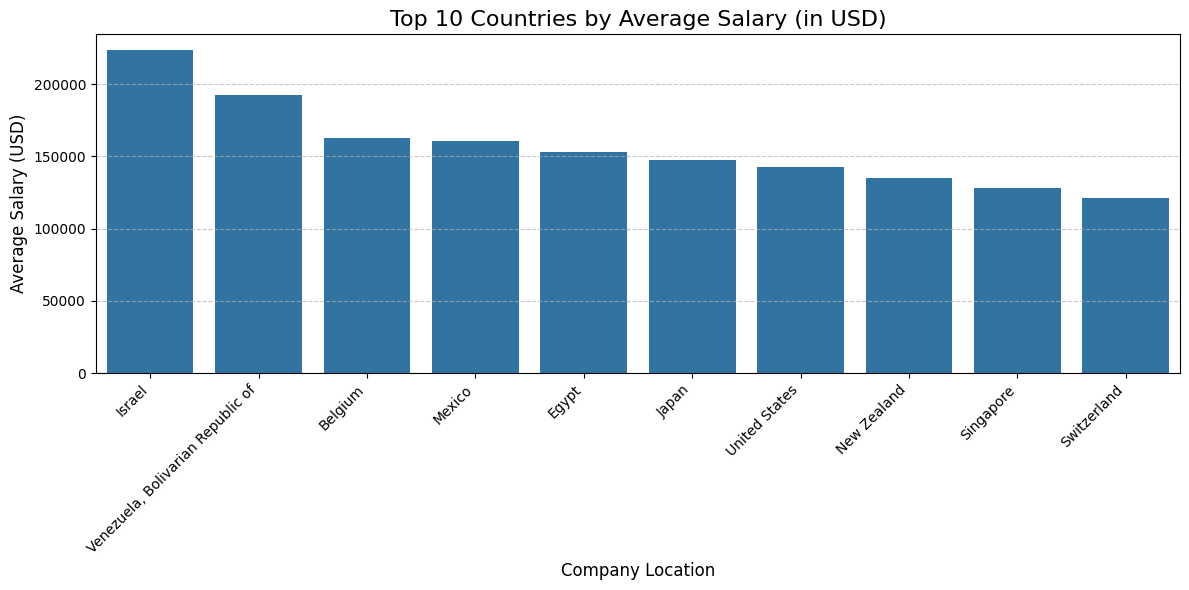

In [ ]:
# Group the filtered dataset by company location and calculate the average salary
country_salary_distribution = (
    df_aggregated.groupby('company_location')['salary_in_usd']
    .mean()
    .sort_values(ascending=False)
)

# Select the top 10 countries with the highest average salary
top_10_countries = country_salary_distribution.head(10)

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_countries.index,
    y=top_10_countries.values,
)

# Customize the chart
plt.title("Top 10 Countries by Average Salary (in USD)", fontsize=16)
plt.xlabel("Company Location", fontsize=12)
plt.ylabel("Average Salary (USD)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.show()

**Location Count Threshold Filtering for Aggregated Data**
*   This step is designed to filter out locations that have fewer than the
specified threshold of records.
*   Removing locations with sparse data helps ensure that the salary trends we analyze are statistically relevant and not skewed by outliers or underrepresented regions.
*   This threshold is flexible and can be adjusted based on the nature of the dataset and the desired balance between including more locations and maintaining statistical reliability.
*   **Threshold of 50:** Retains 3 countries (United States, United Kingdom, and Canada).
*   This decision was made to ensure a sufficient sample size for reliable salary analysis by location, given that the aggregated dataframe still contains 211 unique job titles.
*   Countries with fewer than 50 observations, such as Germany and others, were excluded to avoid having job titles with too few data points, which could lead to statistical instability.







In [ ]:
# Define the threshold for location count filtering
threshold = 50

# Filter the dataset to keep locations with counts greater than or equal to the threshold
filtered_location_counts = location_counts[location_counts >= threshold]

# Filter the main dataset (df_aggregated) to include only the locations that meet the threshold
df_filtered_location = df_aggregated[df_aggregated['company_location'].isin(filtered_location_counts.index)]

# Identify the rows that were removed due to the threshold filter
removed_rows_location = df_aggregated[~df_aggregated['company_location'].isin(filtered_location_counts.index)]

# Save the removed rows to a CSV file for reference
removed_rows_location.to_csv("removed_rows_location.csv", index=False)

# Print the summary of the filtering process
removed_rows_count = len(removed_rows_location)
print(f"Rows removed due to location count threshold: {removed_rows_count}")
print(f"Dataset size after location filtering: {df_filtered_location.shape[0]} rows.")

Rows removed due to location count threshold: 408
Dataset size after location filtering: 1034 rows.


**Distribution of Company Location Counts**

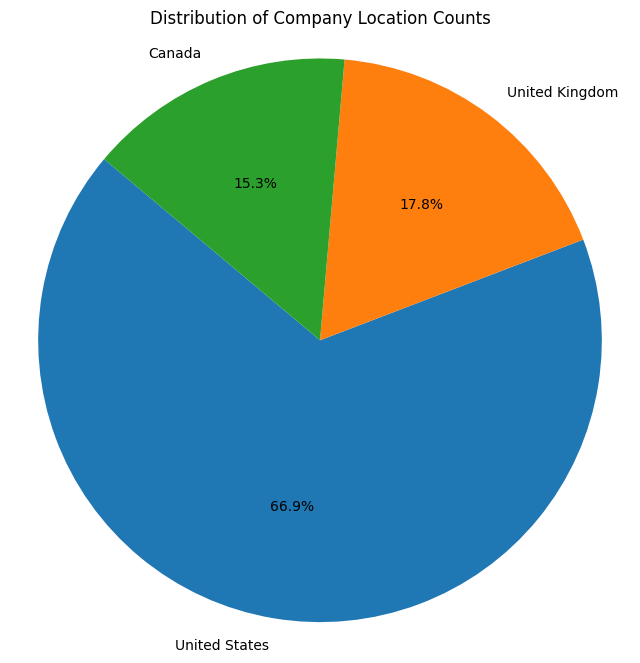

In [ ]:
# Count the occurrences of each company location
location_counts = df_filtered_location['company_location'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Company Location Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Plot Salary Distribution for Outlier Detection**

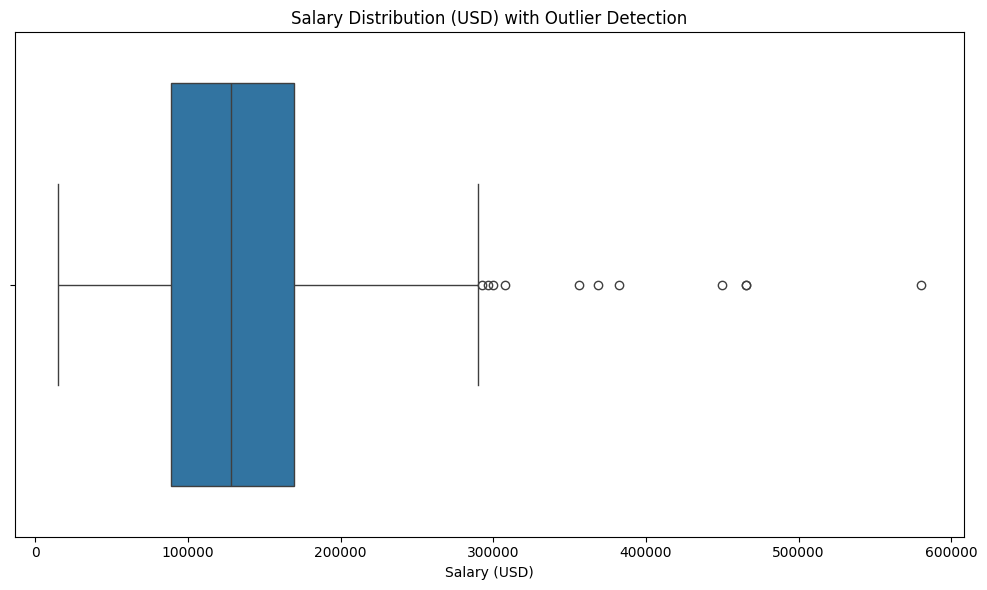

In [ ]:
# Set up the plot size
plt.figure(figsize=(10, 6))

# Create a boxplot for the 'salary_in_usd' column without any categorization
sns.boxplot(x=df_filtered_location['salary_in_usd'])

# Set plot title and labels
plt.title('Salary Distribution (USD) with Outlier Detection')
plt.xlabel('Salary (USD)')

# Show the plot
plt.tight_layout()
plt.show()

**Capping Outliers in Salary Data**
*   In this step, salary values that fall outside the 5th and 95th percentiles for each combination of work year, experience level, company location, and company size are capped.
*   Job title is not capped because with a high number of unique job titles, the cap would have minimal effect on the data.
*   This approach helps mitigate the influence of extreme salary values, ensuring that the data is more representative of typical salary trends within each group.





In [ ]:
def cap_outliers_by_key_factors(df_filtered_location):
    """
    Caps outliers in the 'salary_in_usd' column based on a combination of work year, experience level,
    company location, and company size (excluding job title).

    Parameters:
    - df_filtered_location (pandas.DataFrame): The filtered dataframe containing salary information.

    Returns:
    - pandas.DataFrame: A new dataframe with capped outliers.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df_capped = df_filtered_location.copy()

    # Loop through each combination of work year, employment level, company location, and company size
    for (year, experience, location, size) in df_capped.groupby(['work_year', 'experience_level', 'company_location', 'company_size']).groups:
        # Filter the dataframe for this combination
        group_df = df_capped[
            (df_capped['work_year'] == year) &
            (df_capped['experience_level'] == experience) &
            (df_capped['company_location'] == location) &
            (df_capped['company_size'] == size)
        ]

        # Calculate the 5th and 95th percentiles for salary within this group
        lower_percentile = np.percentile(group_df['salary_in_usd'], 5)
        upper_percentile = np.percentile(group_df['salary_in_usd'], 95)

        # Cap salaries outside the 5th-95th percentile range
        df_capped.loc[
            (df_capped['work_year'] == year) &
            (df_capped['experience_level'] == experience) &
            (df_capped['company_location'] == location) &
            (df_capped['company_size'] == size) &
            (df_capped['salary_in_usd'] < lower_percentile), 'salary_in_usd'] = lower_percentile

        df_capped.loc[
            (df_capped['work_year'] == year) &
            (df_capped['experience_level'] == experience) &
            (df_capped['company_location'] == location) &
            (df_capped['company_size'] == size) &
            (df_capped['salary_in_usd'] > upper_percentile), 'salary_in_usd'] = upper_percentile

    # Identify capped outliers
    capped_outliers = df_filtered_location[df_filtered_location['salary_in_usd'] != df_capped['salary_in_usd']]

    # Save the capped outliers to a CSV file
    capped_outliers.to_csv("capped_outliers.csv", index=False)

    # Print how many rows were capped
    print(f"{len(capped_outliers)} rows were capped based on work year, experience level, company location, and company size.")

    return df_capped

# Apply the capping function to the df_filtered_location dataframe
df_capped_key_factors = cap_outliers_by_key_factors(df_filtered_location)

# Check the size of the dataset after capping
print(f"Dataset size after capping: {len(df_capped_key_factors)}")


149 rows were capped based on work year, experience level, company location, and company size.
Dataset size after capping: 1034


**Salary Distribution Comparison: Before and After Capping Outliers**

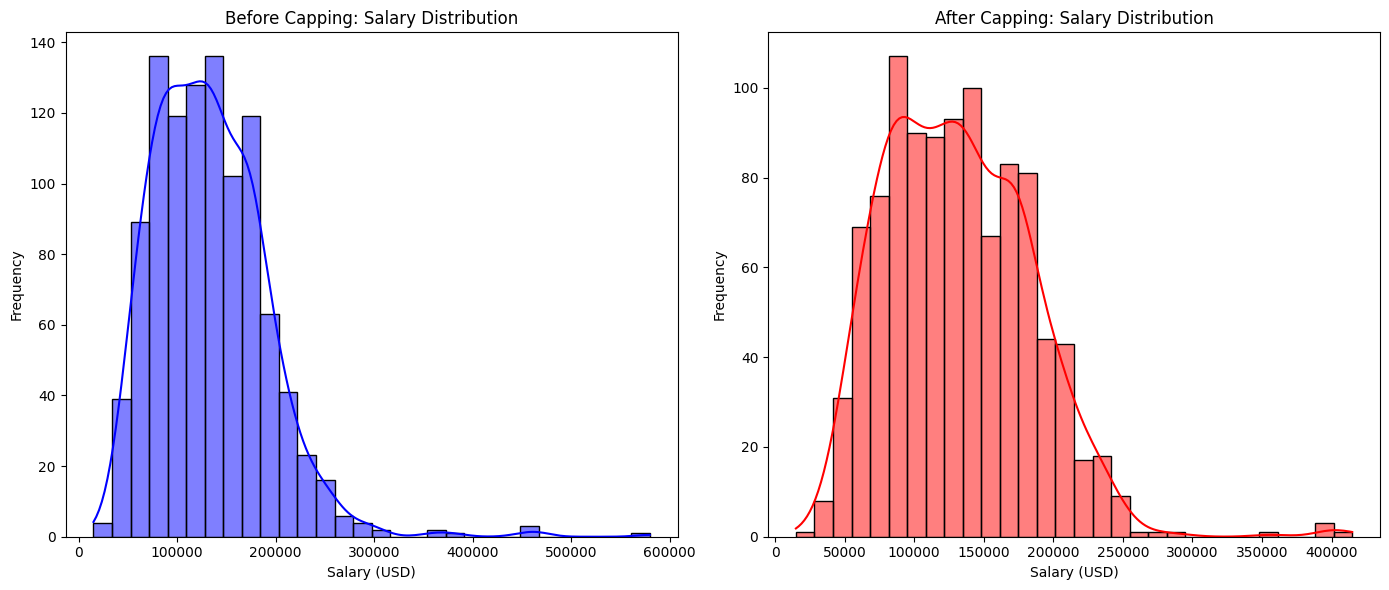

KS-statistic: 0.0222, p-value: 0.9603
The distributions are not significantly different.


In [ ]:
# Set up the plot size and layout for side-by-side plots
plt.figure(figsize=(14, 6))

# Plot 1: Histogram of salary distribution before capping
plt.subplot(1, 2, 1)
sns.histplot(df_filtered_location['salary_in_usd'], kde=True, color='blue', bins=30)
plt.title('Before Capping: Salary Distribution')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')

# Plot 2: Histogram of salary distribution after capping
plt.subplot(1, 2, 2)
sns.histplot(df_capped_key_factors['salary_in_usd'], kde=True, color='red', bins=30)
plt.title('After Capping: Salary Distribution')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')

# Adjust the layout for better spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

# Perform a Kolmogorov-Smirnov test to compare salary distributions
ks_stat, p_value = ks_2samp(df_filtered_location['salary_in_usd'], df_capped_key_factors['salary_in_usd'])

# Print the result
print(f"KS-statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

# Interpretation:
if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

*   Although extreme values have been capped, the underlying salary distribution remains almost identical.
*   The test results confirm that the capping process did not introduce significant distortion in the data.
*   It effectively handled the outliers but left the rest of the data structure intact.






**Drop Columns Not required for the Analysis**

In [ ]:
df_cleaned = df_capped_key_factors.drop(columns=['employment_type', 'remote_ratio', 'employee_residence', 'salary_currency'])

**Cleaned Dataset Overview**

In [ ]:
df_cleaned.head()

,work_year,experience_level,job_title,company_location,company_size,salary_in_usd
5,2020,Executive,Staff Data Analyst,Canada,Medium,15000.0
6,2020,Mid-Level,BI Data Analyst,United States,Medium,98000.0
7,2020,Mid-Level,Business Data Analyst,United States,Medium,95300.0
13,2020,Mid-Level,Research Scientist,United States,Medium,414800.0
17,2021,Entry-Level,Applied Data Scientist,United Kingdom,Large,110037.0


**Cleaned Dataset Info**

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 5 to 1441
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   work_year         1034 non-null   int64  
 1   experience_level  1034 non-null   object 
 2   job_title         1034 non-null   object 
 3   company_location  1034 non-null   object 
 4   company_size      1034 non-null   object 
 5   salary_in_usd     1034 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 56.5+ KB


**Summary of Removed and Adjusted Rows**

In [ ]:
# Print detailed summary
print("\n--- Data Cleaning Summary ---")

# Non-Full-Time and Non-In-Office filtering
print(f"Rows removed due to non-full-time positions: {removed_rows_full_time:,} rows")
print(f"Rows removed due to non-in-office positions: {removed_rows_in_office:,} rows")

# Aggregation process
print(f"Rows removed during aggregation: {len(removed_rows_aggregated):,} rows")

# Location Count filtering
print(f"Rows removed due to location count threshold: {removed_rows_location.shape[0]:,} rows")

# Capping outliers
# We will count the rows that had salary values changed after capping.
capped_outliers_count = len(df_filtered_location[df_filtered_location['salary_in_usd'] != df_capped_key_factors['salary_in_usd']])
print(f"Rows capped as outliers: {capped_outliers_count:,} rows")

# Dataset size after all steps
print(f"Dataset size after filtering and capping: {df_capped_key_factors.shape[0]:,} rows")

# Save final cleaned dataset
df_cleaned.to_csv("cleaned_data.csv", index=False)
print("\nCleaned data saved to 'cleaned_data.csv'.")



--- Data Cleaning Summary ---
Rows removed due to non-full-time positions: 231 rows
Rows removed due to non-in-office positions: 13,219 rows
Rows removed during aggregation: 44,763 rows
Rows removed due to location count threshold: 408 rows
Rows capped as outliers: 149 rows
Dataset size after filtering and capping: 1,034 rows

Cleaned data saved to 'cleaned_data.csv'.


#**Exploratory Data Analysis (EDA)**

**Check the Structure of the Dataset**

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 5 to 1441
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   work_year         1034 non-null   int64  
 1   experience_level  1034 non-null   object 
 2   job_title         1034 non-null   object 
 3   company_location  1034 non-null   object 
 4   company_size      1034 non-null   object 
 5   salary_in_usd     1034 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 56.5+ KB


**Summary Statistics for Numeric Columns (*salary_in_usd*)**

In [ ]:
salary_stats = df_cleaned['salary_in_usd'].describe()
print(salary_stats)

count      1034.000000
mean     131613.386122
std       52428.926078
min       15000.000000
25%       89478.750000
50%      128658.750000
75%      169291.875000
max      414800.000000
Name: salary_in_usd, dtype: float64


**Salary Distribution Histogram**

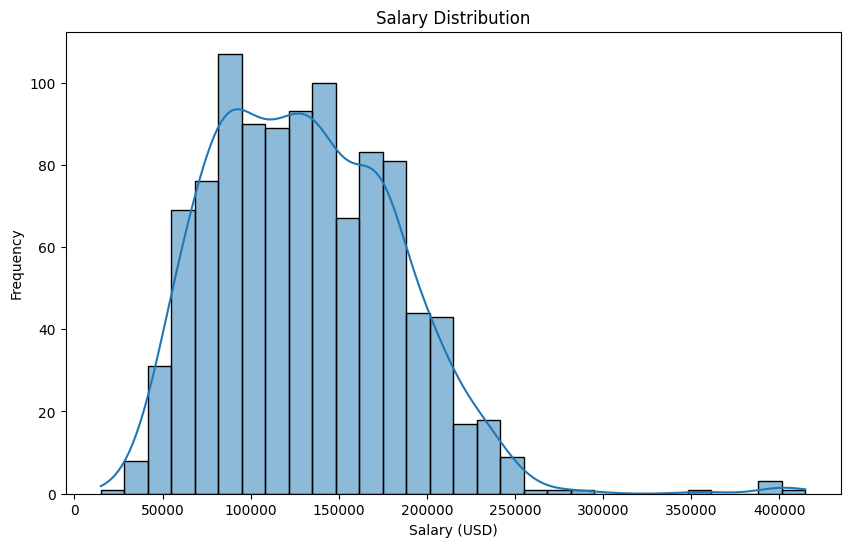

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['salary_in_usd'], kde=True, bins=30)
plt.title('Salary Distribution')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.show()

**Salary Distribution by Experience Level in 2024**

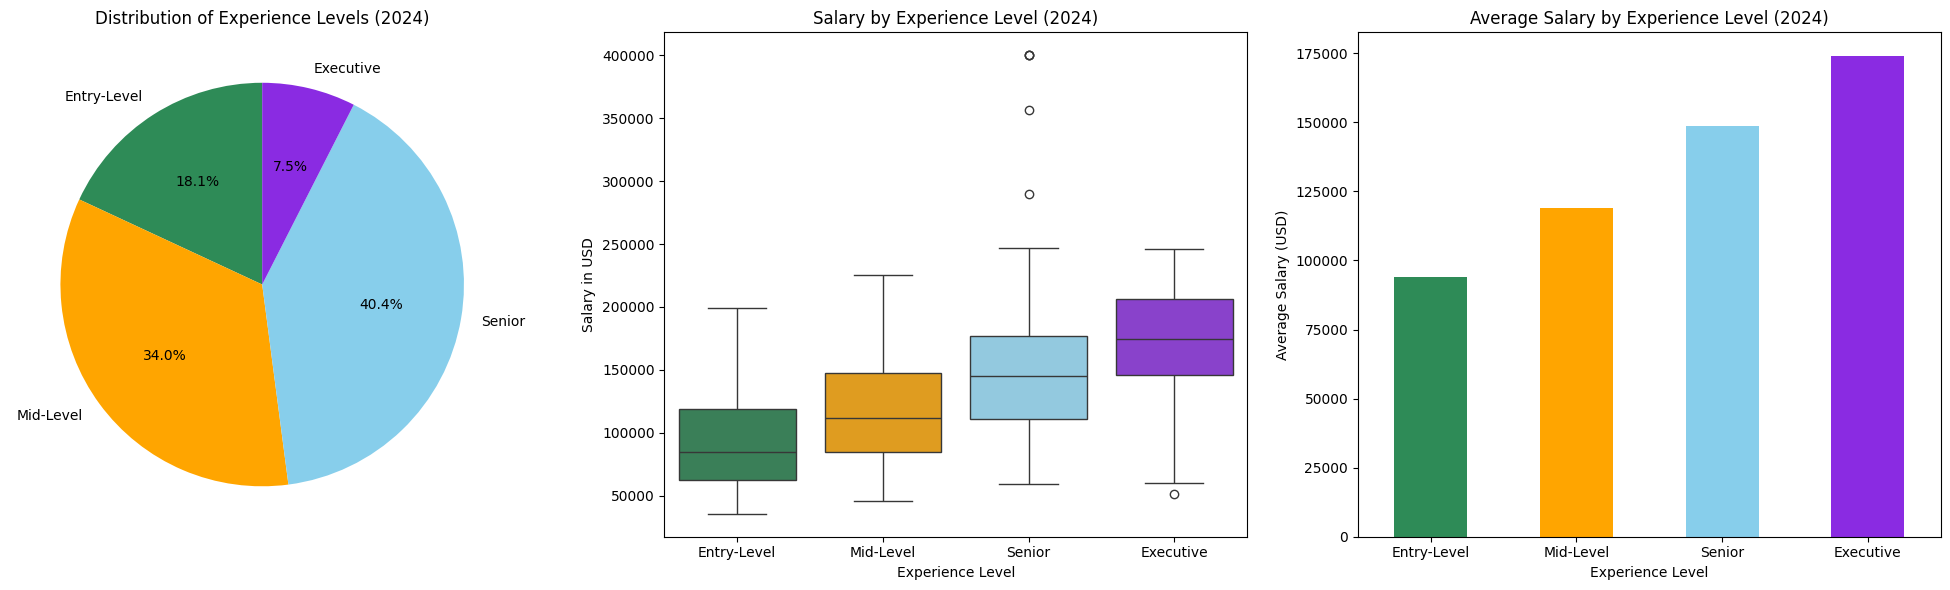

In [ ]:
# Filter the data for 2024
df_2024 = df_cleaned[df_cleaned['work_year'] == 2024]

# Ensure experience levels are in the desired order
experience_order = ['Entry-Level', 'Mid-Level', 'Senior', 'Executive']

# Calculate the count of each experience level for 2024, with the specified order
experience_counts_2024 = df_2024['experience_level'].value_counts().reindex(experience_order)

# Define colors for each experience level
experience_colors = {
    'Entry-Level': '#2E8B57',  # Green
    'Mid-Level': '#FFA500',    # Orange
    'Senior': '#87CEEB',       # Light Blue
    'Executive': '#8A2BE2'     # Purple
}

# Group by experience level and calculate the average salary for 2024
salary_by_experience_2024 = df_2024.groupby('experience_level')['salary_in_usd'].mean().reindex(['Entry-Level', 'Mid-Level', 'Senior', 'Executive'])

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the Pie Chart in the first subplot with labels directly on the pie chart
axes[0].pie(experience_counts_2024, autopct='%1.1f%%', startangle=90, colors=['#2E8B57', '#FFA500', '#87CEEB', '#8A2BE2'],
            labels=experience_counts_2024.index)  # Add labels directly to the pie chart
axes[0].set_title('Distribution of Experience Levels (2024)')
axes[0].set_ylabel('')  # Hide the y-axis label

# Plot the Box Plot in the second subplot (No legend)
sns.boxplot(data=df_2024, x='experience_level', y='salary_in_usd',
            hue='experience_level',
            order=['Entry-Level', 'Mid-Level', 'Senior', 'Executive'],
            palette=experience_colors, legend=False, ax=axes[1])  # legend=False to remove the boxplot legend
axes[1].set_title('Salary by Experience Level (2024)')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary in USD')

# Plot the Bar Chart in the third subplot
salary_by_experience_2024.plot(kind='bar', color=['#2E8B57', '#FFA500', '#87CEEB', '#8A2BE2'], ax=axes[2])
axes[2].set_title('Average Salary by Experience Level (2024)')
axes[2].set_xlabel('Experience Level')
axes[2].set_ylabel('Average Salary (USD)')
axes[2].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Salary Distribution by Experience Level in 2024 Descriptive Statistics**

In [ ]:
# Filter the data for 2024
df_2024 = df_cleaned[df_cleaned['work_year'] == 2024]

# Group by experience level and calculate descriptive statistics for salary
salary_stats_2024 = df_2024.groupby('experience_level')['salary_in_usd'].describe().reindex(['Entry-Level', 'Mid-Level', 'Senior', 'Executive'])

# Calculate additional statistics for salary distribution
salary_by_experience_2024 = df_2024.groupby('experience_level')['salary_in_usd'].mean().reindex(['Entry-Level', 'Mid-Level', 'Senior', 'Executive'])

# Combine the statistics for easy comparison
final_stats_2024 = salary_stats_2024[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].join(salary_by_experience_2024.rename('average_salary'))

# Display the final statistics
print(final_stats_2024)

                  count           mean           std      min        25%  \
experience_level                                                           
Entry-Level       135.0   93953.645185  39330.454796  35625.0   62500.00   
Mid-Level         254.0  118841.224213  43947.469120  45921.3   84491.25   
Senior            302.0  148740.390894  53011.514439  59125.0  111250.00   
Executive          56.0  173866.467857  44010.581714  51486.8  145815.00   

                       50%          75%        max  average_salary  
experience_level                                                    
Entry-Level        85000.0  118981.5000  198793.05    93953.645185  
Mid-Level         111934.0  147630.8750  225000.00   118841.224213  
Senior            145050.0  176846.2125  400000.00   148740.390894  
Executive         174440.0  206272.1250  246090.00   173866.467857  


- Entry-Level roles have an average salary of 93,954.
- Mid-Level roles earn an average of 118,841.
- Senior roles have an average salary of 148,740.
- Executive roles earn an average of 173,866.

- As experience level increases, salary variability also rises:
  - Entry-level positions show lower salary variance.
  - Senior and executive roles exhibit wider salary ranges, suggesting greater diversity in job responsibilities and compensation packages.

- Higher positions (Senior and Executive) show larger salary discrepancies, which could be influenced by factors such as:
  - Company size
  - Industry
  - Role specialization

- Overall, experience level strongly influences salary, with higher positions commanding substantially higher pay, but with increased variability.


**Salary Distribution by Company Size in 2024**

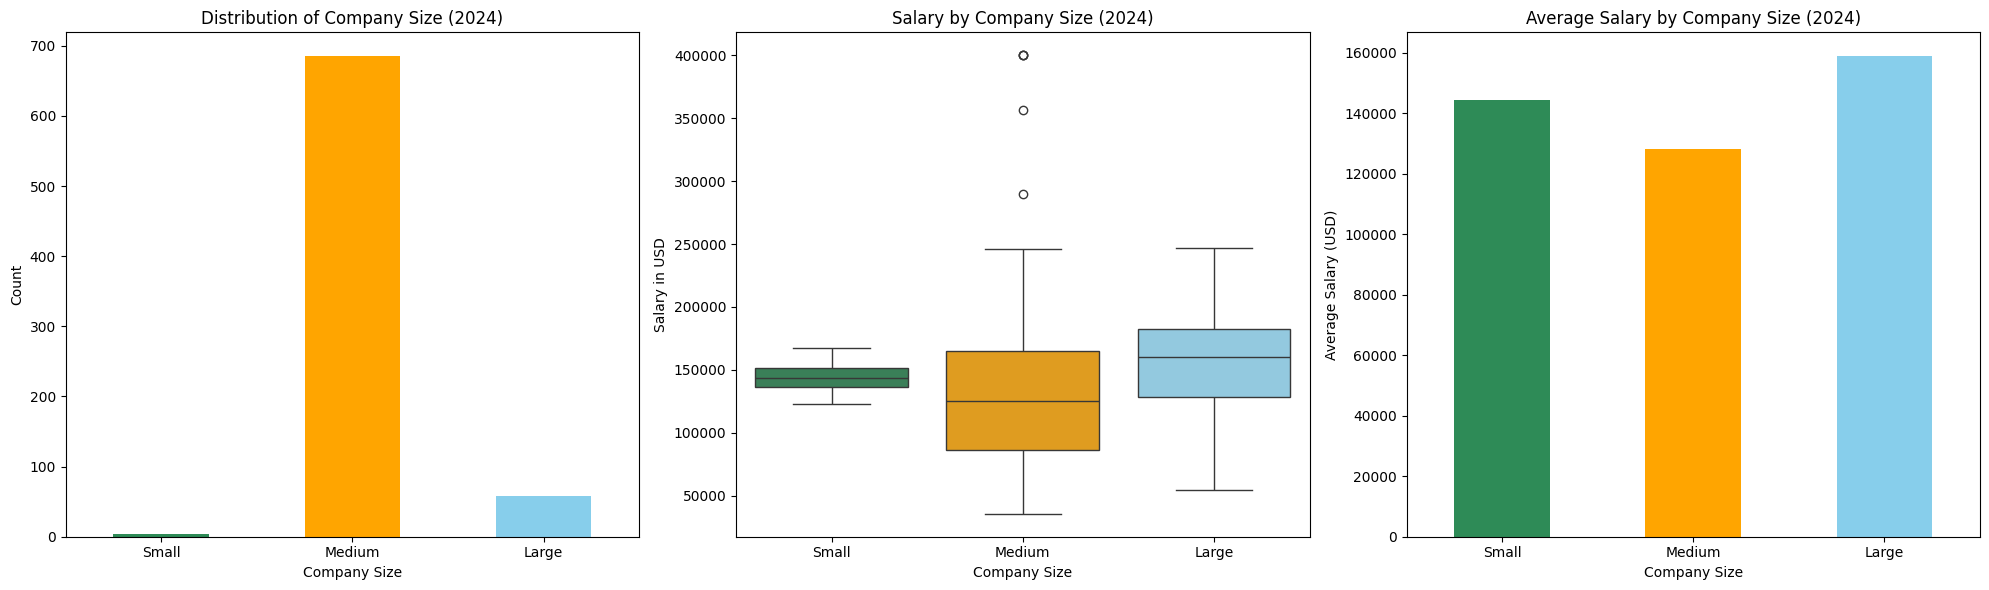

In [ ]:
df_2024 = df_cleaned[df_cleaned['work_year'] == 2024]

# Define company size categories (you can adjust these as needed based on the dataset)
company_size_order = ['Small', 'Medium', 'Large']

# Calculate the count of each company size for 2024
company_size_counts_2024 = df_2024['company_size'].value_counts().reindex(company_size_order)

# Define colors for each company size
company_size_colors = {
    'Small': '#2E8B57',  # Green
    'Medium': '#FFA500',    # Orange
    'Large': '#87CEEB'       # Light Blue
}

# Group by company size and calculate the average salary for 2024
salary_by_company_size_2024 = df_2024.groupby('company_size')['salary_in_usd'].mean().reindex(company_size_order)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the Bar Chart in the first subplot
company_size_counts_2024.plot(kind='bar', color=['#2E8B57', '#FFA500', '#87CEEB'], ax=axes[0])
axes[0].set_title('Distribution of Company Size (2024)')
axes[0].set_xlabel('Company Size')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Plot the Box Plot in the second subplot (No legend)
sns.boxplot(data=df_2024, x='company_size', y='salary_in_usd',
            hue='company_size',
            order=company_size_order,
            palette=company_size_colors, legend=False, ax=axes[1])  # legend=False to remove the boxplot legend
axes[1].set_title('Salary by Company Size (2024)')
axes[1].set_xlabel('Company Size')
axes[1].set_ylabel('Salary in USD')

# Plot the Bar Chart in the third subplot
salary_by_company_size_2024.plot(kind='bar', color=['#2E8B57', '#FFA500', '#87CEEB'], ax=axes[2])
axes[2].set_title('Average Salary by Company Size (2024)')
axes[2].set_xlabel('Company Size')
axes[2].set_ylabel('Average Salary (USD)')
axes[2].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Salary Distribution by Company Size in 2024 Descriptive Statistics**

In [ ]:
# Group by company size and calculate descriptive statistics for salary
salary_stats_company_size_2024 = df_2024.groupby('company_size')['salary_in_usd'].describe().reindex(['Small', 'Medium', 'Large'])

# Calculate additional statistics for salary distribution by company size
salary_by_company_size_2024 = df_2024.groupby('company_size')['salary_in_usd'].mean().reindex(['Small', 'Medium', 'Large'])

# Combine the statistics for easy comparison
final_stats_company_size_2024 = salary_stats_company_size_2024[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].join(salary_by_company_size_2024.rename('average_salary'))

# Display the final statistics
print(final_stats_company_size_2024)

              count           mean           std       min         25%  \
company_size                                                             
Small           4.0  144377.150000  18339.126240  123125.0  136242.725   
Medium        685.0  128079.019708  52869.427437   35625.0   86000.000   
Large          58.0  158860.279310  42841.320315   54438.6  128512.500   

                    50%         75%       max  average_salary  
company_size                                                   
Small         143384.15  151518.575  167615.3   144377.150000  
Medium        125000.00  165260.000  400000.0   128079.019708  
Large         160050.00  182813.125  247065.0   158860.279310  


- **Small companies:** Average salary of 144,377, with low variability (std dev: 18,339). Only 4 records remain after data cleaning, which limits the conclusions that can be drawn.
- **Medium companies:** Average salary of 128,079, with high variability (std dev: 52,869).
- **Large companies:** Average salary of 158,860, with moderate variability (std dev: 42,841).
- Salary increases with company size, with large companies offering the highest pay.
- Medium-sized companies exhibit the highest salary variability.

**Salary Distribution by Company Location in 2024**

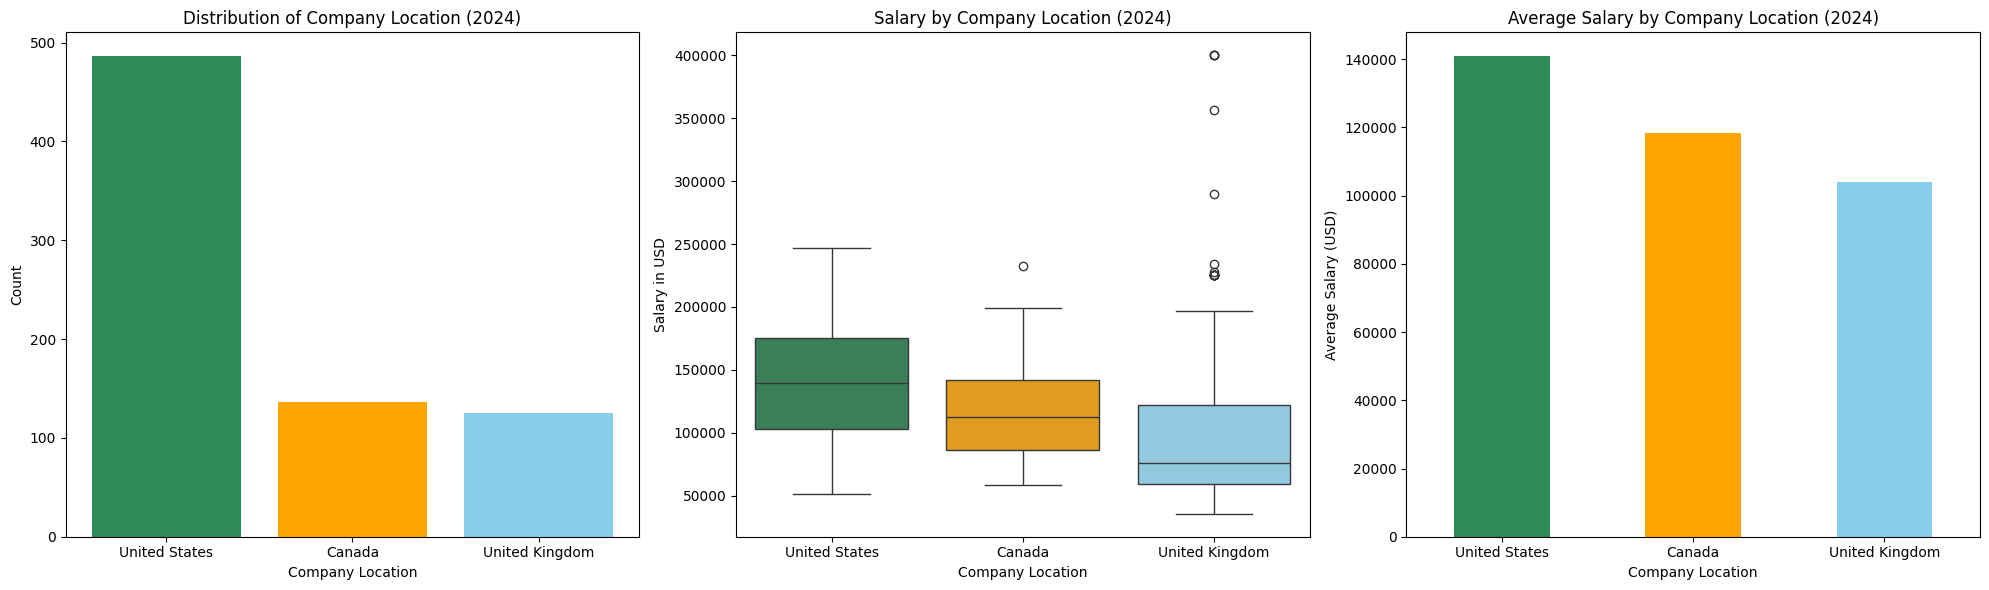

In [ ]:
# Filter the data for 2024
df_2024 = df_cleaned[df_cleaned['work_year'] == 2024]

# Calculate the count of each company location for 2024
company_location_counts_2024 = df_2024['company_location'].value_counts()

# Define the colors for company locations
company_location_colors = {
    'United States': '#2E8B57',  # Green
    'Canada': '#FFA500',         # Orange
    'United Kingdom': '#87CEEB', # Light Blue
}

# Define the specific order of locations
ordered_locations = ['United States', 'Canada', 'United Kingdom']

# Map each company location to its assigned color
location_color_map = {location: company_location_colors.get(location, '#87CEEB')
                      for location in ordered_locations}

# Group by company location and calculate the average salary for 2024
salary_by_company_location_2024 = df_2024.groupby('company_location')['salary_in_usd'].mean()

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot the Bar Chart in the first subplot
axes[0].bar(company_location_counts_2024.index, company_location_counts_2024, color=[location_color_map.get(loc, '#87CEEB') for loc in company_location_counts_2024.index])
axes[0].set_title('Distribution of Company Location (2024)')
axes[0].set_xlabel('Company Location')
axes[0].set_ylabel('Count')

# Explicitly set x-ticks and labels in the first plot
axes[0].set_xticks(range(len(ordered_locations)))  # Set tick positions based on the order
axes[0].set_xticklabels(ordered_locations)  # Set the order of company locations

# Plot the Box Plot in the second subplot (No legend)
sns.boxplot(data=df_2024, x='company_location', y='salary_in_usd',
            hue='company_location',
            order=ordered_locations,  # Use the ordered locations
            palette=location_color_map, legend=False, ax=axes[1])  # Use the predefined color map
axes[1].set_title('Salary by Company Location (2024)')
axes[1].set_xlabel('Company Location')
axes[1].set_ylabel('Salary in USD')

# Plot the Bar Chart for Average Salary in the third subplot
salary_by_company_location_2024.loc[ordered_locations].plot(kind='bar', color=[location_color_map[loc] for loc in ordered_locations], ax=axes[2])
axes[2].set_title('Average Salary by Company Location (2024)')
axes[2].set_xlabel('Company Location')
axes[2].set_ylabel('Average Salary (USD)')
axes[2].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Salary Distribution by Company Location in 2024 Descriptive Statistics**

In [ ]:
# Group by company location and calculate descriptive statistics for salary
salary_stats_company_location_2024 = df_2024.groupby('company_location')['salary_in_usd'].describe().reindex(['United States', 'Canada', 'United Kingdom'])

# Calculate additional statistics for salary distribution by company location
salary_by_company_location_2024 = df_2024.groupby('company_location')['salary_in_usd'].mean().reindex(['United States', 'Canada', 'United Kingdom'])

# Combine the statistics for easy comparison
final_stats_company_location_2024 = salary_stats_company_location_2024[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].join(salary_by_company_location_2024.rename('average_salary'))

# Display the final statistics
print(final_stats_company_location_2024)

                  count           mean           std       min         25%  \
company_location                                                             
United States     486.0  140832.410134  46170.323465  51050.00  103386.000   
Canada            136.0  118240.119669  36926.781869  58339.55   86115.125   
United Kingdom    125.0  104002.605600  74645.007155  35625.00   59125.000   

                       50%       75%       max  average_salary  
company_location                                                
United States     139450.0  174937.5  247065.0   140832.410134  
Canada            112334.0  141601.5  232750.0   118240.119669  
United Kingdom     75737.5  122010.0  400000.0   104002.605600  


- **United States:**

  - Average salary: 140,832.41
  - Salary range: 51,050 to 247,065
  - Standard deviation: 46,170.32

- **Canada:**

  - Average salary: 118,240.12
  - Salary range: 58,340 to 232,750
  - Standard deviation: 36,926.78

- **United Kingdom:**

  - Average salary: 104,002.61
  - Salary range: 35,625 to 400,000
  - Standard deviation: 74,645.01

- The U.S. has the highest average salary and the broadest salary range.
- Canada demonstrates more consistency in salary distribution, with a narrower range and lower variation.
- The United Kingdom shows the lowest average salary but with significant outliers, highlighting high salary disparities.

**Salary Distribution by Job Title in 2024**

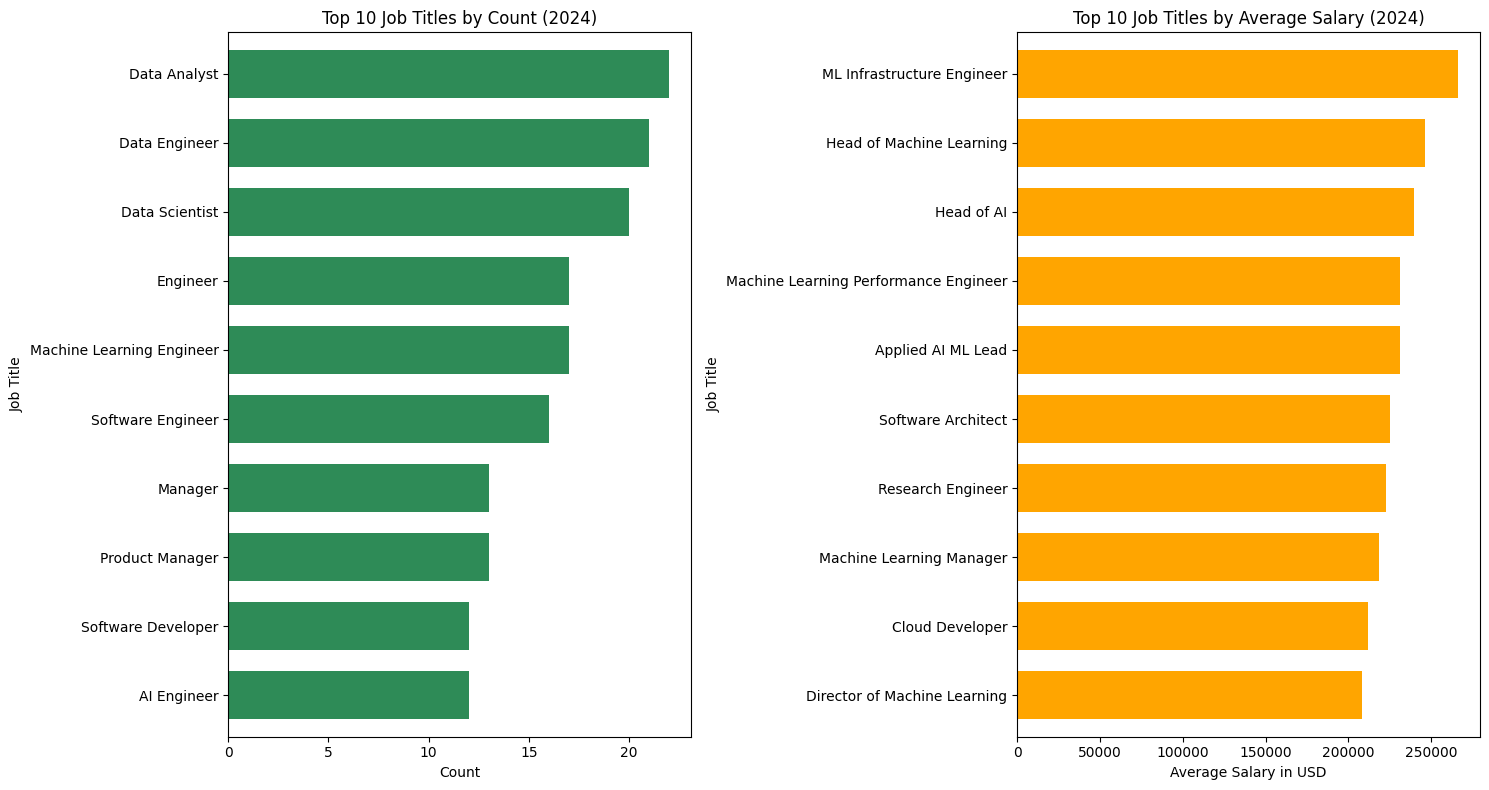

In [ ]:
# Filter the data for 2024
df_2024 = df_cleaned[df_cleaned['work_year'] == 2024]

# Top 10 most common job titles by count, ordered in descending order (highest first)
top_job_titles_by_count = df_2024['job_title'].value_counts().head(10).sort_values(ascending=False)

# Top 10 job titles by average salary, ordered in descending order (highest first)
top_job_titles_by_salary = df_2024.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).head(10)

# Define the colors
count_colors = ['#2E8B57']
salary_colors = ['#FFA500']

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the bar chart for top 10 job titles by count, ordered by highest first
top_job_titles_by_count.plot(kind='barh', color=count_colors, ax=axes[0], width=0.7)
axes[0].set_title('Top 10 Job Titles by Count (2024)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Job Title')
axes[0].invert_yaxis()  # Inverts the y-axis so the highest count is at the top

# Plot the bar chart for top 10 job titles by average salary, ordered by highest first
top_job_titles_by_salary.plot(kind='barh', color=salary_colors, ax=axes[1], width=0.7)
axes[1].set_title('Top 10 Job Titles by Average Salary (2024)')
axes[1].set_xlabel('Average Salary in USD')
axes[1].set_ylabel('Job Title')
axes[1].invert_yaxis()  # Inverts the y-axis so the highest salary is at the top

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**Salary Distribution by Job Title in 2024 Descriptive Statistics**

In [ ]:
# Group by job title and calculate descriptive statistics for salary
salary_stats_job_title_2024 = df_2024.groupby('job_title')['salary_in_usd'].describe()

# Calculate additional statistics for salary distribution by job title
salary_by_job_title_2024 = df_2024.groupby('job_title')['salary_in_usd'].mean()

# Combine the statistics for easy comparison
final_stats_job_title_2024 = salary_stats_job_title_2024[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].join(salary_by_job_title_2024.rename('average_salary'))

# Select the top 10 job titles by count (most frequent job titles)
top_10_job_titles_by_count = final_stats_job_title_2024.nlargest(10, 'count')

# Select the top 10 job titles by average salary
top_10_job_titles_by_salary = final_stats_job_title_2024.nlargest(10, 'average_salary')

# Display the results
print("Top 10 Job Titles by Count:")
print(top_10_job_titles_by_count)
print("\nTop 10 Job Titles by Average Salary:")
print(top_10_job_titles_by_salary)

Top 10 Job Titles by Count:
                           count           mean           std        min  \
job_title                                                                  
Data Analyst                22.0   85244.868182  27489.705590  44381.000   
Data Engineer               21.0  103560.317857  38607.384944  51050.000   
Data Scientist              20.0  114776.620000  45328.117674  39612.500   
Engineer                    17.0  117577.794118  44337.888736  62000.000   
Machine Learning Engineer   17.0  165288.352941  40624.532314  60608.500   
Software Engineer           16.0  151649.937500  55768.303477  53125.000   
Manager                     13.0  125292.423077  51204.252815  45000.000   
Product Manager             13.0  154976.644231  49571.487162  64541.875   
AI Engineer                 12.0  131605.775000  35275.264254  87500.000   
Analyst                     12.0   85242.316667  25788.738615  53125.000   

                                  25%        50%         75

- **Top 10 Job Titles by Count (2024):**
  - Data Analyst, Data Engineer, and Data Scientist are the most frequent roles.
  - These positions show a wide range of salaries, with higher-paid roles like Machine Learning Engineer and Software Engineer present in the top 10.
  - These roles are typically more common across different companies and job markets.

- **Top 10 Job Titles by Average Salary (2024):**
  - The highest-paying roles include ML Infrastructure Engineer, Head of Machine Learning, and Head of AI.
  - These positions, while offering higher compensation, are less common, indicating that specialized skills and leadership are highly valued.
  - The average salaries for these roles can be influenced by the presence of lower-frequency observations (e.g., only one or two instances), which can skew the results.

- **Key Observations:**
  - It's important to consider that lower-frequency job titles can affect the ranking of high-paying roles in the dataset.

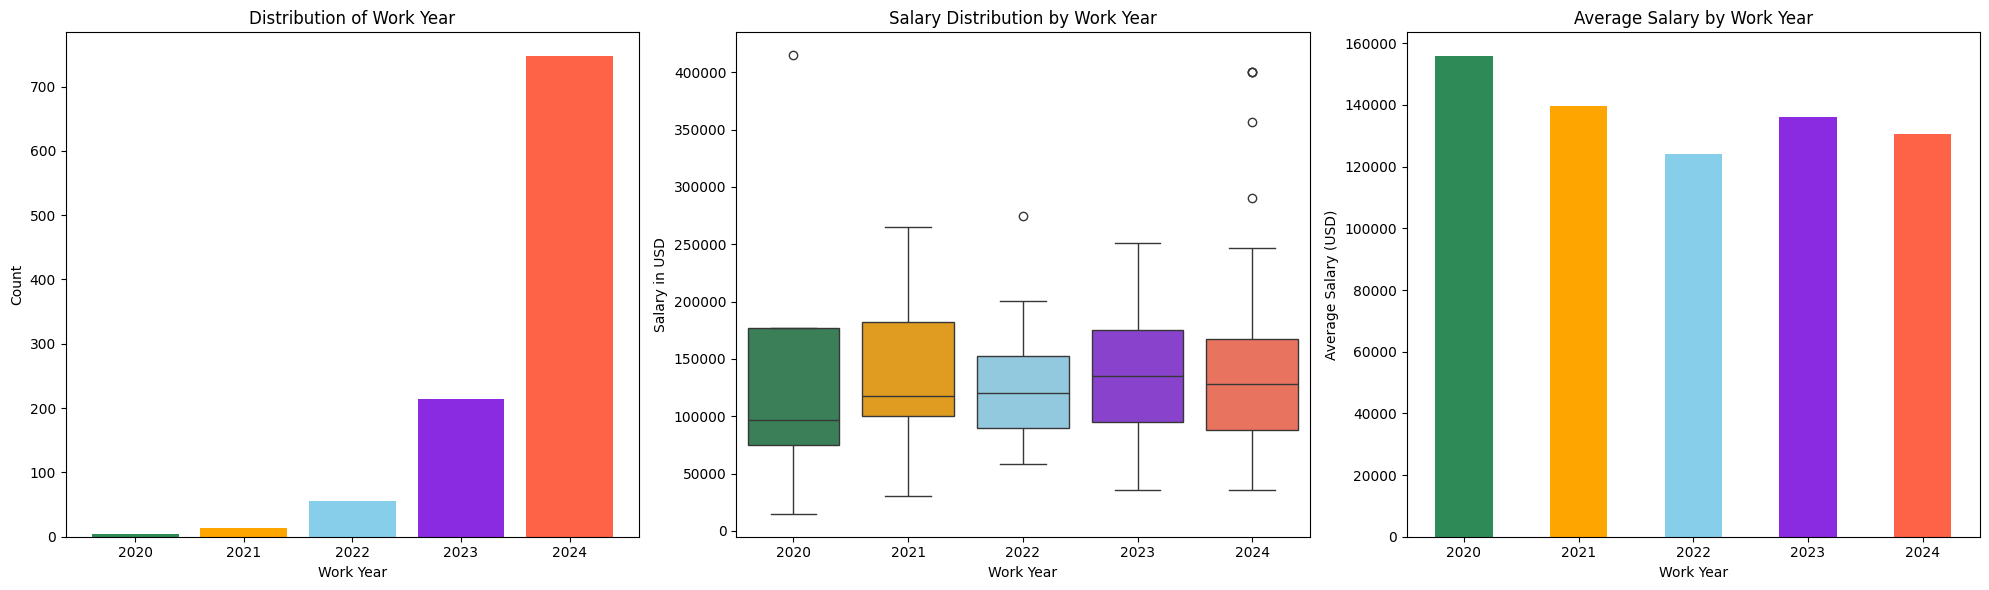

In [ ]:
# Define the custom color palette (with 5 distinct colors)
color_palette = ['#2E8B57', '#FFA500', '#87CEEB', '#8A2BE2', '#FF6347']
# Create a figure with 3 subplots for work year analysis and salary
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Bar Chart - Distribution of work years
work_year_counts = df_cleaned['work_year'].value_counts().sort_index()

# Plotting the bar chart
axes[0].bar(work_year_counts.index, work_year_counts, color=color_palette[:len(work_year_counts)])
axes[0].set_title('Distribution of Work Year')
axes[0].set_xlabel('Work Year')
axes[0].set_ylabel('Count')

# Plot 2: Box Plot - Salary distribution by work year
sns.boxplot(data=df_cleaned, x='work_year', y='salary_in_usd',
            hue='work_year', palette=color_palette[:len(work_year_counts)], ax=axes[1], legend=False)  # Added hue='work_year' to avoid the warning
axes[1].set_title('Salary Distribution by Work Year')
axes[1].set_xlabel('Work Year')
axes[1].set_ylabel('Salary in USD')

# Plot 3: Bar Plot - Average salary by work year
average_salary_by_year = df_cleaned.groupby('work_year')['salary_in_usd'].mean().sort_index()
average_salary_by_year.plot(kind='bar', color=color_palette[:len(work_year_counts)], ax=axes[2])  # Use the custom color palette
axes[2].set_title('Average Salary by Work Year')
axes[2].set_xlabel('Work Year')
axes[2].set_ylabel('Average Salary (USD)')
axes[2].tick_params(axis='x', rotation=0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Group by work year and calculate descriptive statistics for salary
salary_stats_work_year = df_cleaned.groupby('work_year')['salary_in_usd'].describe().reindex([2020, 2021, 2022, 2023, 2024])

# Calculate additional statistics for salary distribution by work year
salary_by_work_year = df_cleaned.groupby('work_year')['salary_in_usd'].mean().reindex([2020, 2021, 2022, 2023, 2024])

# Combine the statistics for easy comparison
final_stats_work_year = salary_stats_work_year[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].join(salary_by_work_year.rename('average_salary'))

# Display the final statistics
print(final_stats_work_year)

           count           mean            std      min         25%       50%  \
work_year                                                                       
2020         4.0  155775.000000  176924.397696  15000.0   75225.000   96650.0   
2021        14.0  139793.142857   70035.355625  30254.5  100615.625  118018.5   
2022        55.0  124198.155455   43358.732623  58000.0   89635.750  120000.0   
2023       214.0  136222.455140   48434.495388  35496.5   95089.000  135000.0   
2024       747.0  130556.269478   52663.109610  35625.0   87738.750  128000.0   

                 75%       max  average_salary  
work_year                                       
2020       177200.00  414800.0   155775.000000  
2021       181875.00  264800.0   139793.142857  
2022       152700.00  275000.0   124198.155455  
2023       175000.00  251525.0   136222.455140  
2024       167557.65  400000.0   130556.269478  


- **Salary by Work Year Analysis:**
  - **2020:** Average salary of 155,775 with high variability (std: 176,924) due to only 4 data points.
  - **2021:** Average salary of 139,793 with lower variability (std: 70,035), but based on just 14 data points.
  - **2022:** Average salary dropped to 124,198 with a tighter salary range and more data (55 observations).
  - **2023:** Average salary increased to 136,222 with a more balanced distribution (214 observations).
  - **2024:** Average salary at 130,556, with a standard deviation of 52,663, showing continued salary variability (747 observations).

- **Key Observations:**
  - The lower count in 2020 and 2021 may have skewed salary averages, as these years have fewer data points.
  - Salary trends show fluctuations, but 2023 and 2024 reflect a more stable distribution due to higher data counts.
  - Standard deviation remains high across the years, suggesting variability in salaries within each year.